# Anomaly Detection: STEP2

## Outline
1. Introduction  
2. Import Module  
3. Load Dataset
    - 3.1 Description
    - 3.2 Difine Anomalies
4. Split Dataset(Train, Test)
5. Exploratory Data Analysis
    - 5.1 Distribution
    - 5.2 Correlation
6. Implementation Anomaly Detection

# Introduction
[UCI machine learning repository](https://archive.ics.uci.edu/ml/index.php)의 [Covertype Data Set](https://archive.ics.uci.edu/ml/datasets/Covertype)를 이용하여 Point Anomalies 탐지 구현을 목표로 하는 커널이다.

주어진 원 데이터는 581,012개의 행과 55개의 열로 구성되어 있으며, Target 변수를 제외하고 10개의 수치형 변수와 44개의 범주형 변수이다. 

Target 변수는 총 7 개의 값을 가지고 있다. 

이상 탐지 구현은 수치형 변수 10개만 가지고 수행할 것이다.

# Import Module

In [29]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

from pyod.models.ocsvm import OCSVM
from pyod.models.iforest import IForest
from pyod.models.xgbod import XGBOD

import xgboost as xgb
from xgboost import XGBClassifier

import warnings
import os
warnings.filterwarnings('ignore')
print(os.listdir('../dataset/forest_cover_type'))

['covtype.csv']


# Load Data

In [30]:
data = pd.read_csv('../dataset/forest_cover_type/covtype.csv')
print("Data Set Shape: ", data.shape)

Data Set Shape:  (581012, 55)


In [31]:
data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


## Description
데이터가 생성된 지역은 콜로라도 북부에 있는 루즈벨트 국립 숲에 위치한 네 개의 황무지 지역이다. 네 개의 황무지에 대한 몇 가지 배경 정보는 다음과 같다. 
- Neota(Area 2): 네 개의 지역 중 가장 높은 평균 고도값을 가진다.
- Rawah(Area 1), Comanche Peak(Area 3): 네 개의 지역 중 중간 정도 평균 고도값을 가진다.
- Cache la Poudre(Area 4): 네 개의 지역 중 평균 고도값이 가장 낮다.

Neota에 Spruce/fir(1)가 많이 서식하는 반면, Rawah와 Comanche Peak에는 Lodgepole Pine(2)와 Aspen(5)가 많이 서식한다.

Cache la Poudre에는 Ponderosa Pine(3), Douglas-fir(6), Cottonwood/Willow(4)가 많이 서식하는 경향이 있다. 

마지막으로, Krummholz(7)는 데이터 설명 상 등장하지 않지만, 특징을 보아 Neota에 서식할 가능성이 높다.

Cache la Poudre는 다른 지역보다 낮은 고도와 나무의 종류로 인해 다른 지역과 차이를 보인다.

구현에 사용할 변수는 다음과 같다.
- Elevation: 해발 고도
- Aspect: 방위각
- Slope: 경사 등급
- Horizontal_Distance_To_Hydrology: 가장 가까운 지표수까지의 수평 거리
- Vertical_Distance_To_Hydrology: 가장 가까운 지표수까지의 수직 거리
- Horizontal_Distance_To_Roadways: 가장 가까운 도로까지의 수평 거리
- Hillshade_9am (0 to 255 index): 여름철 오전 9시에 발생한 그늘의 정도
- Hillshade_Noon (0 to 255 index): 여름철 정오에 발생한 그늘의 정도
- Hillshade_3pm (0 to 255 index): 여름철 오후 3시에 발생한 그늘의 정도
- Horizontal_Distance_To_Fire_Points: 가장 가까운 산불 발화지점까지의 수평 거리

In [32]:
label = data['Cover_Type']

data = data.iloc[:, :10]
data['Cover_Type'] = label

data.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,7.000000


In [33]:
tmp = data.copy()

tmp['Anomalies'] = tmp['Cover_Type'].apply(lambda x: 1 if (x == 3) | (x == 4) | (x == 6) else 0)
tmp['Anomalies']

0         0
1         0
2         0
3         0
4         0
         ..
581007    1
581008    1
581009    1
581010    1
581011    1
Name: Anomalies, Length: 581012, dtype: int64

## Define Anomalies
Target 변수는 7개의 값으로 이루어져 있다. 값에 대한 설명은 다음과 같다.
- 1 = <b>Spruce/Fir</b>: 전나무로 불린다.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Black_spruce_stand_at_Arctic_Chalet%2C_Inuvik%2C_NT.jpg/330px-Black_spruce_stand_at_Arctic_Chalet%2C_Inuvik%2C_NT.jpg" width = "250">


- 2 = <b>Lodgepole Pine</b>: 로지폴 소나무로 불린다. 미 서부에 서식하며, 해안 근처와 고산대까지는 많이 관측되지만 저지대에서는 드물다는 특징을 보인다.

<img src="https://www.for.gov.bc.ca/hfd/library/documents/treebook/lodgepolepine.jpg" width = "250">

- 3 = <b>Ponderosa Pine</b>: 폰데로사 소나무로 불린다. 미 서부의 산악지역에 주로 서식하며 이외에도 다양한 곳에서 서식한다.

<img src="https://i.pinimg.com/564x/e9/09/34/e909349f0067010243f448bc8620db2b.jpg" width = "250">

- 4 = <b>Cottonwood/Willow</b>: 사시나무로 불린다. 온대 기후에서 서식한다. 영양 생식을 하기 때문에, 많은 잡종이 생긴다는 특징이 있다.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/16/Populier_Populus_canadensis.jpg/375px-Populier_Populus_canadensis.jpg" width = "250">

- 5 = <b>Aspen</b>: 아스펜이라고 불린다. 여름이 서늘하고 산이나 고원과 같은 높은 고도에서 주로 서식한다. 일반적으로 침엽수 나무가 서식하는 환경에서 자란다.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/29/Snowbowlaspens.jpg/330px-Snowbowlaspens.jpg" width = "250">

- 6 = <b>Douglas-fir</b>: 소나무 과에 속하는 상록수이다. 

<img src="https://cdn.britannica.com/s:700x500/34/118234-050-12C9BAC8/Douglas-fir.jpg" width = "250">

- 7 = <b>Krummholz</b> : 아열대 및 아열 고산에서 나타나는 변종 식물의 일종이다. 매우 추운 바람에 지속적으로 노출되어 나타난다.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d7/Pinus_albicaulis_7872.JPG/330px-Pinus_albicaulis_7872.JPG" width = "250">

Description을 통해 알게된 사실을 토대로, Cache la Poudre 지역에 많이 서식하는 종을 Anomalies로 정한다.

### Create Anomalies Variable

In [5]:
data.loc[(data['Cover_Type'] == 3) | (data['Cover_Type'] == 6) | (data['Cover_Type'] == 4), 'Anomalies'] = 1
data['Anomalies'].fillna(0, inplace = True)

## Train Test Split

In [6]:
X = data.drop(columns = 'Anomalies')
y = data['Anomalies']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, shuffle = True, random_state = 42)

print("Train Data Shape:  {}, {}".format(X_train.shape, y_train.shape))
print("Test Data Shape: {}, {}".format(X_test.shape, y_test.shape))

Train Data Shape:  (464809, 11), (464809,)
Test Data Shape: (116203, 11), (116203,)


# Exploratory Data Analysis

## Anomalies

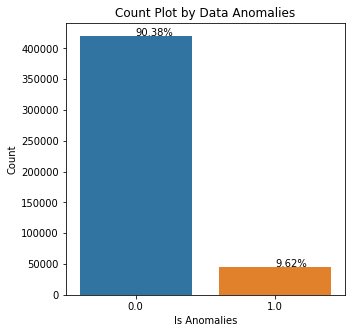

In [7]:
total = len(X_train)

plt.figure(figsize = (5,5))

ax2 = sns.countplot(y_train)

for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width()/ 2.,
           height + 3,
           '{:1.2f}%'.format(height / total *100))

plt.title('Count Plot by Data Anomalies')
plt.xlabel('Is Anomalies')
plt.ylabel('Count')

plt.show()

데이터의 90.38%가 Normal한 값을 가지고, 9.62%가 Anomalies하다는 것을 알 수 있다. 이는 Imbalance 데이터라는 것을 의미하기도 한다. 

이 커널에서는 일반적인 Classification 모델과 Anomaly Detection 모델을 이용하여 각각 어떤 성능이 나올 것인지 비교해보겠다. 

### Distribution

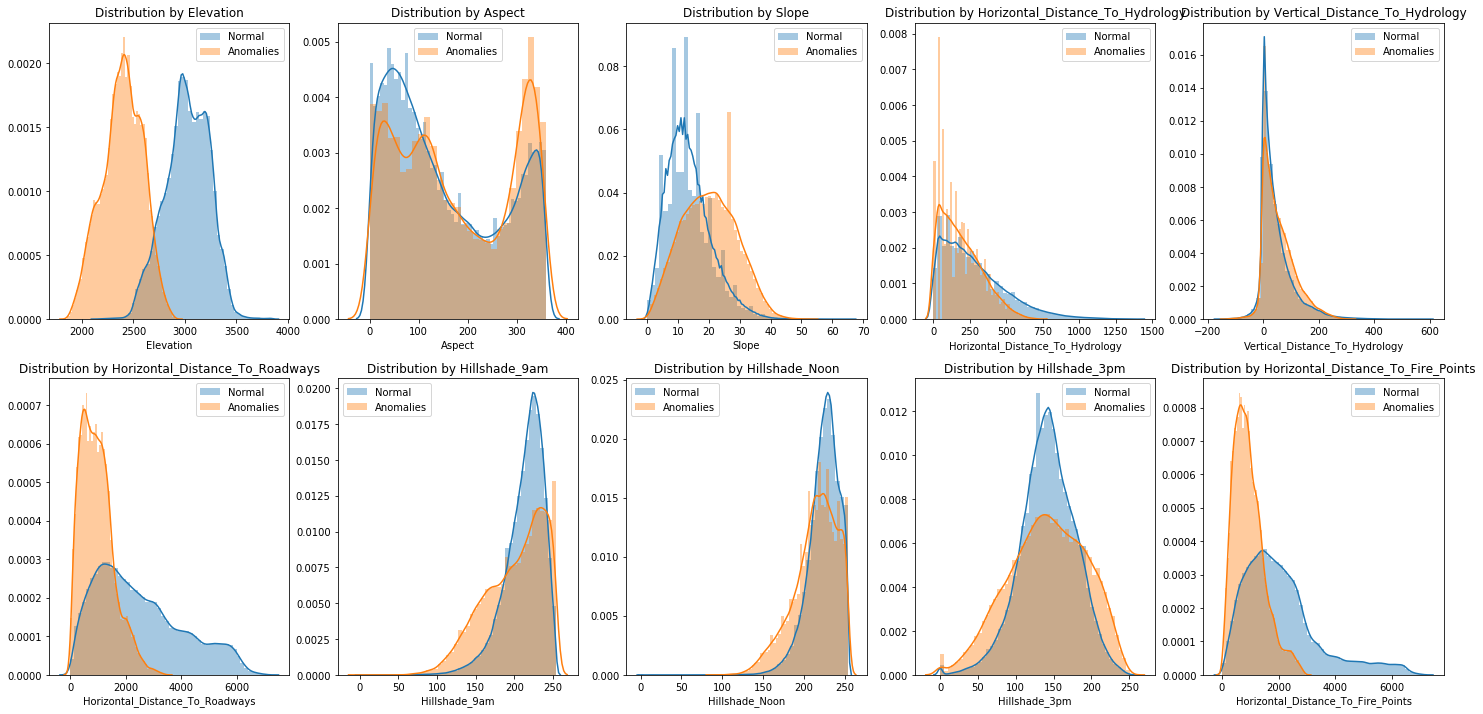

In [8]:
train = pd.concat([X_train, y_train], axis = 1)

f = plt.figure(figsize = (25, 12))

for i, col in enumerate(train.drop(columns = 'Anomalies').columns):
    if i + 1 < 11:
        f.add_subplot(2, 5, i+1)
        sns.distplot(train.loc[train['Anomalies'] == 0][col])
        sns.distplot(train.loc[train['Anomalies'] == 1][col])
        
        plt.legend(labels = ['Normal','Anomalies'],loc = 'best')
        
        plt.title("Distribution by {}".format(col))
        plt.xlabel(col)

### Correlation

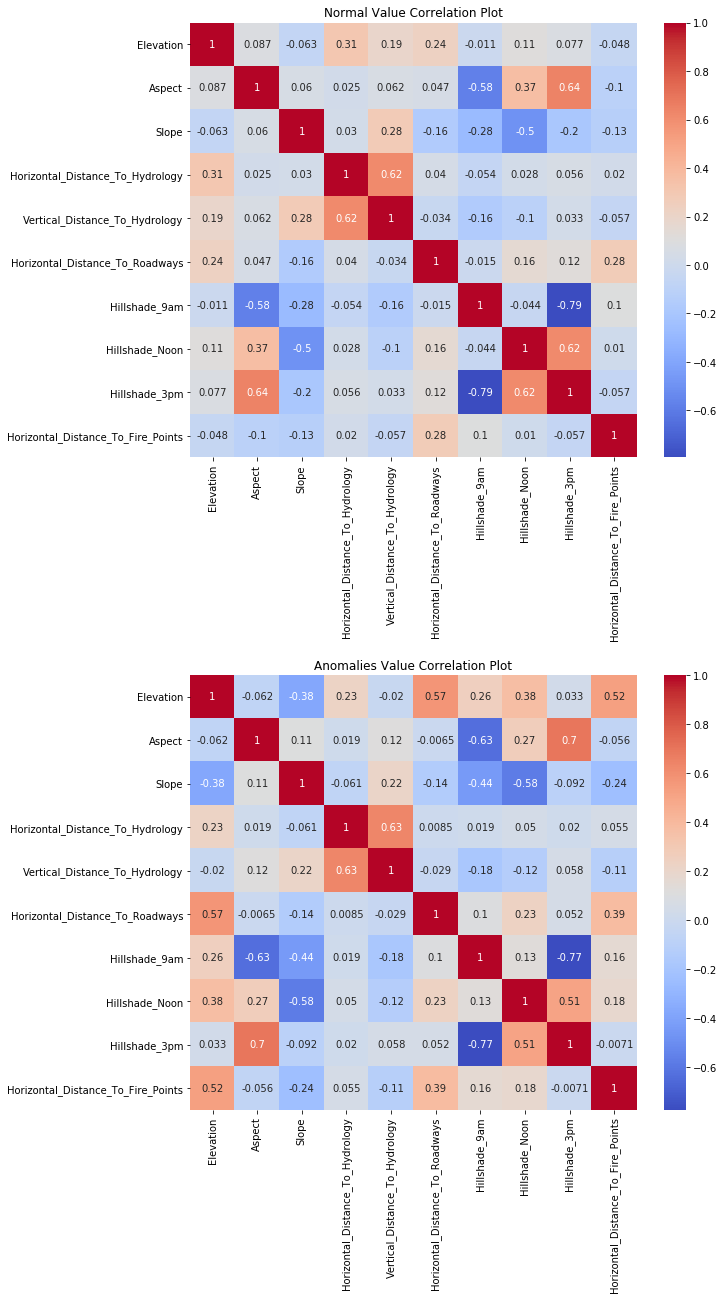

In [9]:
normal_corr = train.loc[train['Anomalies'] == 0].drop(columns = ['Cover_Type', 'Anomalies']).corr()
anomalies_corr = train.loc[train['Anomalies'] == 1].drop(columns = ['Cover_Type', 'Anomalies']).corr()

f = plt.figure(figsize = (10, 20))

f.add_subplot(2, 1, 1)
sns.heatmap(normal_corr, annot = True, cmap = 'coolwarm')

plt.title("Normal Value Correlation Plot")

f.add_subplot(2, 1, 2)
sns.heatmap(anomalies_corr, annot = True, cmap = 'coolwarm')

plt.title('Anomalies Value Correlation Plot')

plt.subplots_adjust(hspace = .5)

plt.show()

### Scatter Plot of Each High Correlation Variable

In [10]:
def Scatterplot(feature1, feature2, data):
    f = plt.figure(figsize = (10, 5))
    
    f.add_subplot(1 ,2, 1)
    
    sns.scatterplot(data.loc[data['Anomalies'] == 1][feature1], data.loc[data['Anomalies'] == 1][feature2],
                   alpha = 0.4, color = 'r')
    
    if len(feature1) | len(feature2) > 8:
        plt.title("{} vs {} \n(Anomalies = {})".format(feature1, feature2, round(data.loc[data['Anomalies'] == 1][[feature1, feature2]].corr().min()[0],2)))
    
    else:
        plt.title("{} vs {} (Anomalies = {})".format(feature1, feature2, round(data.loc[data['Anomalies'] == 1][[feature1, feature2]].corr().min()[0],2)))
    
    f.add_subplot(1, 2, 2)
    sns.scatterplot(data.loc[data['Anomalies'] == 0][feature1], data.loc[data['Anomalies'] == 0][feature2],
                   alpha = 0.4)
    
    if len(feature1) | len(feature2) > 8:
        plt.title("{} vs {} \n(Anomalies = {})".format(feature1, feature2, round(data.loc[data['Anomalies'] == 0][[feature1, feature2]].corr().min()[0],2)))
    
    else:
        plt.title("{} vs {} (Anomalies = {})".format(feature1, feature2, round(data.loc[data['Anomalies'] == 0][[feature1, feature2]].corr().min()[0],2)))
   
    plt.show()
    

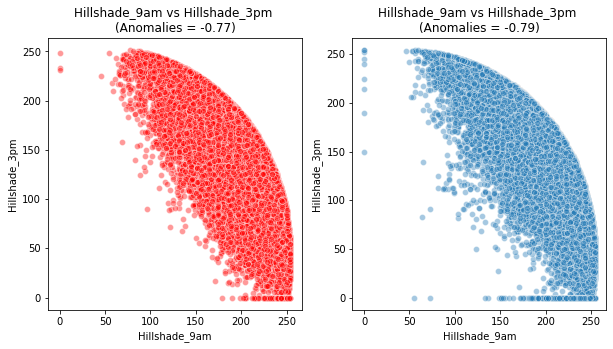

In [11]:
Scatterplot('Hillshade_9am', 'Hillshade_3pm', train)

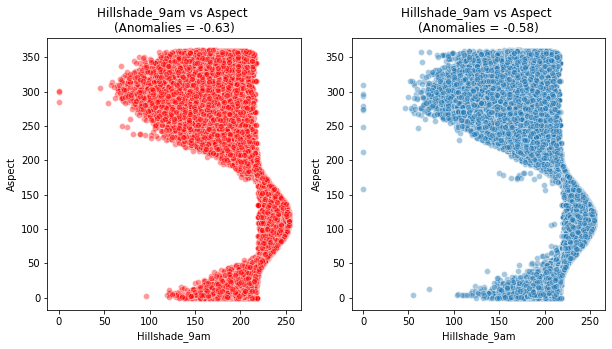

In [12]:
Scatterplot('Hillshade_9am', 'Aspect', train)

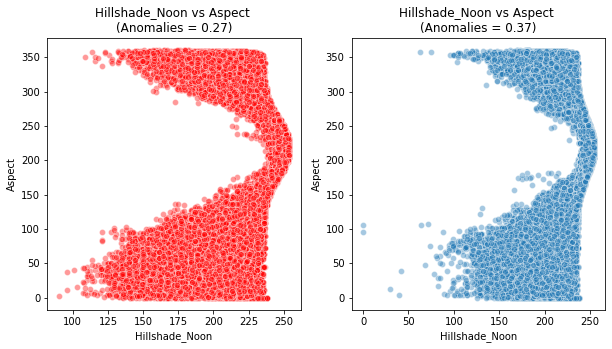

In [13]:
Scatterplot('Hillshade_Noon', 'Aspect', train)

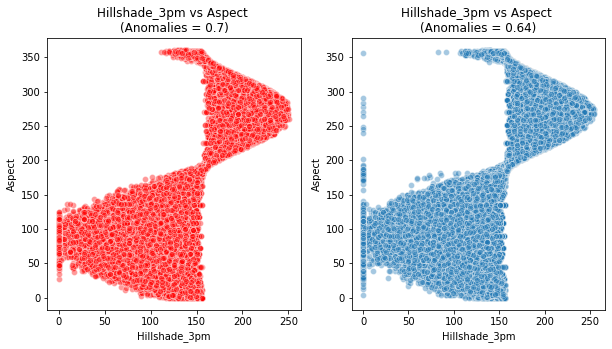

In [14]:
Scatterplot('Hillshade_3pm', 'Aspect', train)

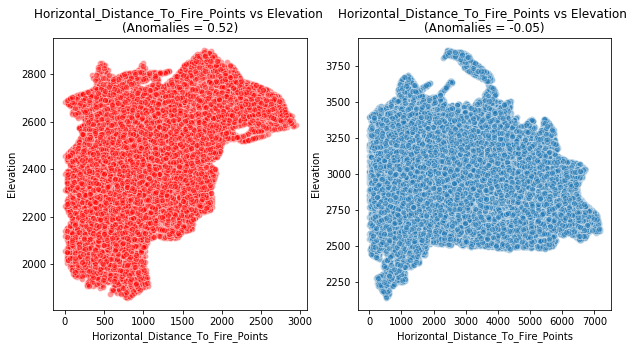

In [15]:
Scatterplot('Horizontal_Distance_To_Fire_Points', 'Elevation', train)

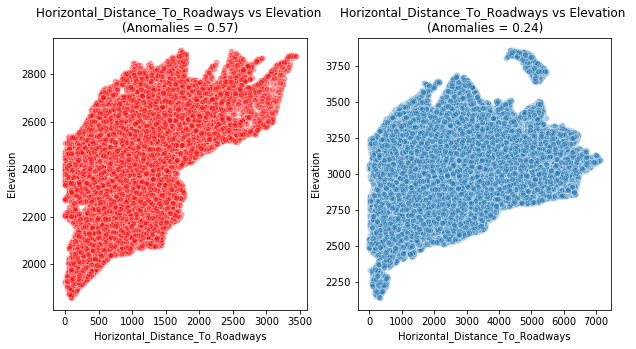

In [16]:
Scatterplot('Horizontal_Distance_To_Roadways', 'Elevation', train)

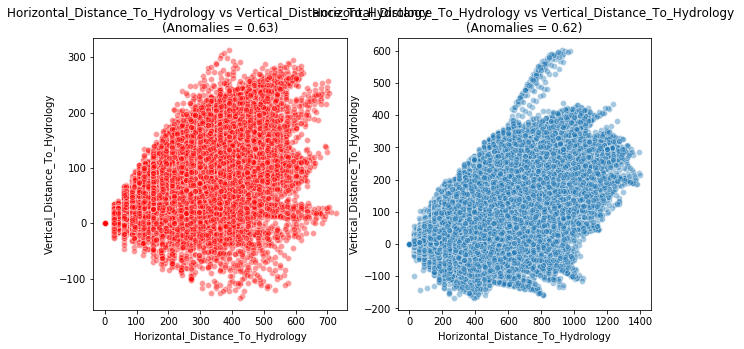

In [17]:
Scatterplot('Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', train)

## Cover_Type

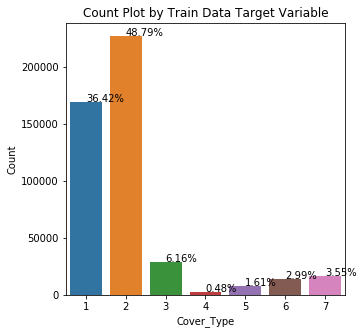

In [18]:
plt.figure(figsize = (5,5))

ax1 = sns.countplot(X_train['Cover_Type'])

for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width()/ 2.,
           height + 3,
           '{:1.2f}%'.format(height / total *100))
    
plt.title("Count Plot by Train Data Target Variable")
plt.ylabel("Count")

plt.show()

Target Variable 중 가장 많은 값을 차지하는 것은 2: 로지폴 소나무로 나타났다. 1: 전나무가 그 뒤를 이었다는 것을 알 수 있다. 

가장 적은 값은 4: 사시나무로 나타났다. 

Cache la Poudre 지역에 서식하는 3: 폰데로사 소나무, 4: 사시나무, 6: 더글라스 소나무를 Anomaly한 값으로 정의하고 이후 분석을 진행한다.

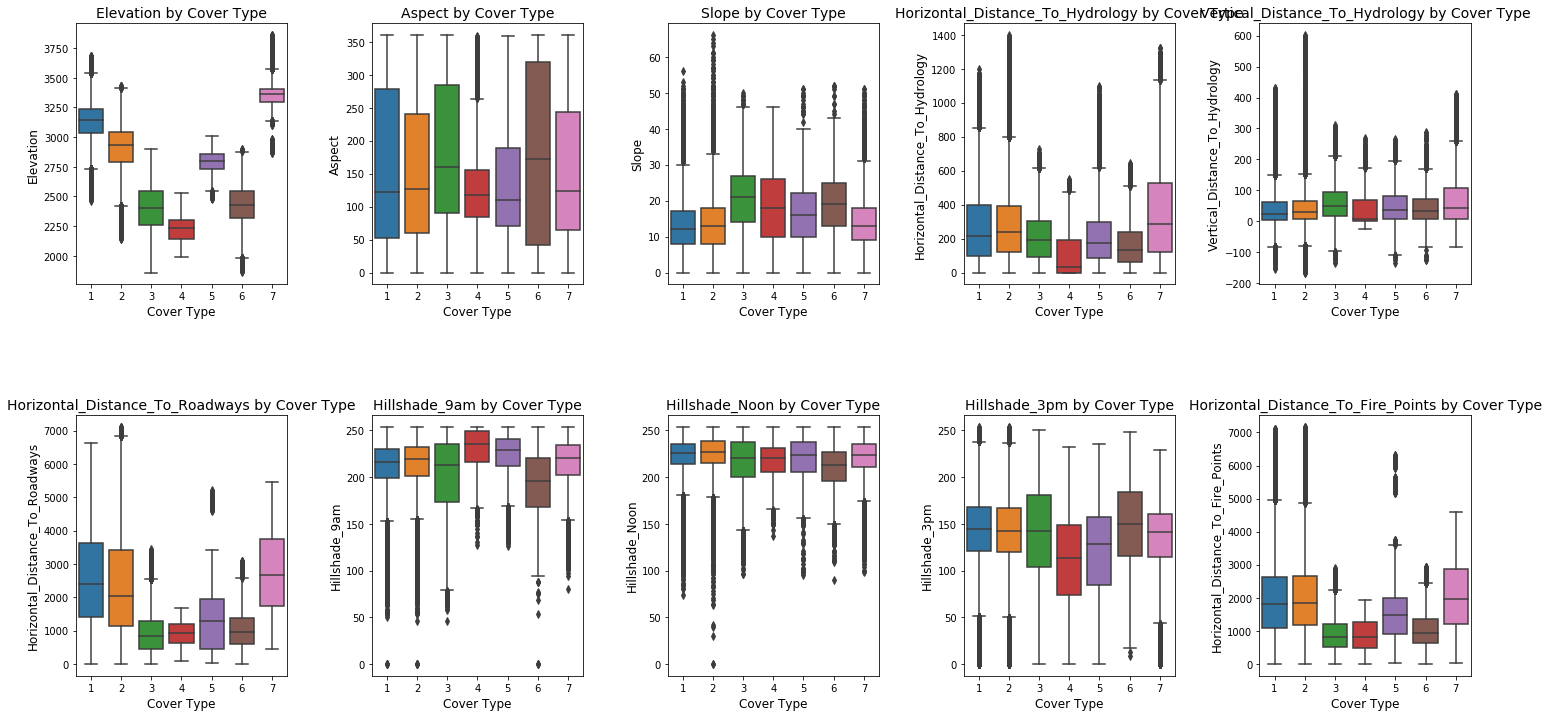

In [19]:
f = plt.figure(figsize = (25,12))

for i, col in enumerate(X_train.drop(columns = ['Cover_Type']).columns):
    if i+1 < 11:
        f.add_subplot(2, 5, i+1)
        sns.boxplot(y = '{}'.format(col), x= 'Cover_Type', data = X_train)
        
        plt.title("{} by Cover Type".format(col), fontsize = 14)
        plt.xlabel("Cover Type", fontsize = 12)
        plt.ylabel("{}".format(col), fontsize = 12)
        plt.subplots_adjust(hspace = 0.5, wspace = 0.4)
    
    else: 
        break 

Cover Type별로 변수들의 분포를 확인해 본 결과는 다음과 같다.
- 고도(Elevation)
    - <b>4: 사시나무</b>는 대체로 저고도에 많이 서식한다.
    - <b>3: 폰데로사 소나무와 6: 더글라스 소나무</b>는 대체로 저고도에 서식한다는 것을 알 수 있다. 그러나 분포가 넓기 때문에 서식 범위가 다소 넓다는 것을 알 수 있다.
    - <b>7: 크룸 홀츠</b>는 사전 알아본 정보와 일치하게 높은 고도에서 서식한다는 것을 알 수 있다. 한 가지 눈에 띄는 점은 정규 분포 가정하에서 이상치가 발생했다는 점이다. 이는 해발 2,750m 이상부터 간헐적으로 크룸 홀츠가 관측된다는 것을 알 수 있다.
    - <b>1: 전나무</b>는 크룸 홀츠의 뒤를 이어 높은 고도에서 서식한다는 것을 알 수 있다. 분포가 넓고 이상치가 발견되었기 때문에 서식 범위가 넓다는 것을 알 수 있다.
    - <b>2: 로지폴 소나무</b>는 중 고도에서 많이 서식한다는 것을 알 수 있다. 분포가 라벨 중 가장 넓은 것을 보아, 서식 범위가 가장 넓다는 것을 알 수 있다.
    - <b>5: 아스펜</b>은 중 고도에서 많이 서식한다는 것을 알 수 있다. 분포가 가장 좁은 것으로 보아, 서식 범위가 매우 제한적이라는 것을 알 수 있다.
    

- Aspect(방위각)

    방위각은 0부터 359의 제한된 값으로 구성되어 있다. 어느 정도 Categorical한 변수이기 때문에, 이를 처리해줄 필요가 있을 것이다. 

    뚜렷한 특징을 보이지 않으나, 두 가지 정도 특징을 확인할 수 있다.
   
    - <b>4: 사시나무</b>는 대부분 0~270 근처에 서식한다. 
    - <b>6: 더글라스 소나무</b>는 가장 많은 방향에서 서식한다.


- Slope
    - <b>2: 로지폴 소나무</b>는 0~60이상 가장 넓은 분포를 보인다. 이는 경사에 큰 영향을 받지 않는 종이라는 것을 알 수 있다.
    - <b>3: 폰데로사 소나무, 4: 사시나무, 6:더글라스 소나무</b>의 중앙값은 다른 종들에 비해 높다는 것을 알 수 있다. 또한, 서식하는 경사도 유사하다는 것을 알 수 있다.
    
    
- Horizontal Distance to Hydrology

    - <b>4: 사시나무</b>는 대부분 지표수와 아주 근접한 위치에 서식한다는 것을 알 수 있다. 사시나무가 습지에 많이 분포한다는 것을 고려하면 예상된 결과일 수 있다.
    - <b>3: 폰데로사 소나무와 6: 더글라스 소나무</b>는 다른 값들에 비해 지표수와 근접한 위치에 서식한다는 것을 알 수 있다. 1, 2, 5, 6은 모두 지표수 부터 800m 이상에 위치한 곳에서도 관측되었다.
    - <b>2: 로지폴 소나무</b>는 주어진 데이터를 통해 사실상, 지표수의 위치와는 별 상관 없이 서식한다는 것을 알 수 있다.
    - <b>1: 전나무와 7: 크롬 홀츠, 5: 아스펜</b>은 지표수로부터 광범위하게 서식한다는 것을 알 수 있다.
    
    
- Vertical Distance to Hydrology

    다른 거리와는 다르게 수직 거리이며, 음수값이 존재한다는 것을 알 수 있다. 데이터 설명에는 따로 기재되있지 않으며, 수직 거리이기 때문에 관측값보다 낮은 고도에 위치한 지표수의 거리는 음수값이라는 것으로 예상된다.  
    
    - <b>2: 로지폴 소나무</b>는 수평 거리에서 확인했듯이, 지표수와의 거리가 서식에 큰 영향을 받지 않는다는 것을 알 수 있다.
    - <b>4: 사시나무</b>는 로지폴 소나무와는 반대로 지표수와의 거리가 서식에 큰 영향을 받는다는 것을 알 수 있다.
    

- Horizontal Distance to Roadways

    - Cache la Poudre지역에 서식하는 <b>3: 폰데로사 소나무, 4: 사시나무, 6: 더글라스 소나무</b>는 도로까지의 수평 거리가 다른 종에 비해 가깝다는 것을 알 수 있다.
    - <b>5: 아스펜</b>은 Cache la Poudre에 서식하는 종과 비슷한 분포를 보이지만, 비교적 멀리 떨어진 지역에서도 서식한다는 것을 알 수 있다.
    - <b>1: 전나무, 2: 로지폴 소나무</b>는 도로까지의 거리에 상관없이 광범위하게 분포한다는 것을 알 수 있다.


- Hillshade

    여름철 오전 9시, 정오, 오후 3시에 관측한 그늘 지수를 확인한 결과는 다음과 같다. 그늘 지수가 높다는 것은 하루 일조량이 낮다는 것이다. 오후 3시에는 전반적으로 모든 종이 다양하게 햇빛을 받았다는 것을 알 수 있다. 
    
    - <b>4: 사시나무</b>는 습지에서 많이 서식한다는 이유로 그늘 지수가 다른 값들보다 높다. 오전 9시는 <b>5: 아스펜</b>과 비슷한 분포를 보이지만, 정오에는 더 높은 분포를 보인다.
    - <b>7: 크롬 홀츠</b>는 오전 9시 그늘 지수가 비교적 높다는 것으로 나타났다. 
    - <b>6: 더글라스 소나무</b>는 오전 9시 그늘 지수가 가장 광범위하게 분포되어 있다.
    - <b>1: 전나무, 2: 로지폴 소나무</b>는 시간대에 상관없이 그늘 지수가 다양하게 분포되어 있다. 이는, 앞서 광범위하게 서식한다는 특징을 보여 나타난 것으로 예상된다.
    
    
- Horizontal Distance To Fire Points
    
    전반적으로 도로까지의 거리와 아주 흡사한 분포를 보인다. 따라서 도로를 지나는 사람으로 인하여 발화가 시작된 것으로 예상된다.
    
    - <b>3: 폰데로사 소나무, 4: 사시나무, 6: 더글라스 소나무</b>는 발화점에서 다른 종들보다 아주 근접한 위치에 서식한다는 것을 알 수 있다. 이는 도로까지의 거리가 가깝기 때문에, 사람의 왕래가 많아 발생한 현상이라고 예상할 수 있다.
    - <b>1: 전나무, 2: 로지폴 소나무</b>는 발화점에서 매우 광범위하게 서식한다는 것을 알 수 있다.
    - <b>5: 아스펜은 도로</b>의 분포와 아주 비슷한것을 알 수 있다. 도로의 거리와 발화점의 거리간 상관관계를 확인해볼 필요가 있다.

# Anomaly Detection using Classification Algorithm (Supervised)

## Preprocessing

In [20]:
X_train.drop(columns = 'Cover_Type', inplace = True)
X_test.drop(columns = 'Cover_Type', inplace = True)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Logistic Regression

In [21]:
rl = LogisticRegression(random_state = 42)
rl.fit(X_train, y_train)

rl_prediction = rl.predict(X_test)

print("Accuracy: ", accuracy_score(rl_prediction, y_test))
print("AUC: ", roc_auc_score(rl_prediction, y_test))

Accuracy:  0.9699491407278642
AUC:  0.9316700214910543


## XGBoost

In [22]:
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_train, y_train)

xgb_prediction = xgb.predict(X_test)

print("Accuracy: ", accuracy_score(xgb_prediction, y_test))
print("AUC: ", roc_auc_score(xgb_prediction, y_test))

Accuracy:  0.9736323502835555
AUC:  0.9433599579546147


## RandomForest

In [28]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)

rf_prediction = rf.predict(X_test)

print("Accuracy: ", accuracy_score(rf_prediction, y_test))
print("AUC: ", roc_auc_score(rf_prediction, y_test))

Accuracy:  0.9950689741228712
AUC:  0.9882083299915254


# Anomaly Detection using Outlier Detection Algorithm

일반적으로, Outlier Detection Algorithm은 Unsupervised Learning이기 때문에 훈련 과정에서 라벨을 필요로하지 않는다.

## Isolation Forest

In [23]:
iforest = IForest()
iforest.fit(X_train)

iforest_prediction = iforest.predict(X_test)

print("Accuracy: ", accuracy_score(iforest_prediction, y_test))
print("AUC: ", roc_auc_score(iforest_prediction, y_test))

Accuracy:  0.8690739481768973
AUC:  0.626782657181172
